# SVGD on 2D Gaussian Mixtures
In this notebook we will see SVGD sampling from a 2D Gaussian mixture. We will also display an animation that shows the movement of the particles
throughout the optimization.

In [1]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import animation
from svgd import SVGD
from svgd.kernels import RbfKernel

We can create a simple Gaussian Mixture from `tensorflow` components, simply scaling the pdf's by a discrete distribution $c$.

In [2]:
class GaussianMixture:
    def __init__(self, comps):
        self.gaussians = [ self.toGaussian(*comp) for comp in comps ]

    def toGaussian(self, c, mean, Cov):
        scale = tf.linalg.cholesky(Cov)
        return (c, tfp.distributions.MultivariateNormalTriL(loc=mean, scale_tril=scale))

    def pdf(self, x):
        return tf.reduce_sum([ c * gaussian.prob(tf.cast(x, tf.float32)) for c, gaussian in self.gaussians], axis = 0)

Now for the animation we use `matplotlib` - pretty standard stuff actually. If you care, unfold the next cell.

In [3]:
def contourData(fn, xrange, yrange):
    x, y = tf.meshgrid(
        tf.linspace(*xrange, 200),
        tf.linspace(*yrange, 200)
    )

    grid = tf.concat([tf.expand_dims(x, -1), tf.expand_dims(y, -1)], -1)
    return x, y, fn(grid)

def particlePlot(svgd, initialParticles, xrange, yrange, saveAnimationTo = None):
    data = contourData(svgd.targetDistribution, xrange, yrange)

    figure = plt.figure()
    plt.axes(xlim = xrange, ylim = yrange)
    plt.contourf(*data, 25)
    cb = plt.colorbar()
    cb.ax.set_ylabel('Density')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('SVGD for 2d Gaussians')

    x = tf.Variable(initialParticles)
    scatter = plt.scatter(x[:, 0], x[:, 1])

    def animate(_, x):
        x = svgd.update(x, 5)
        scatter.set_offsets(x.numpy())
        return scatter,

    anim = animation.FuncAnimation(figure, animate, fargs=(x,), frames=100, blit=True)
    
    if saveAnimationTo is not None:
        anim.save(saveAnimationTo)

We draw initial particles uniformly to spread them across the space. This helps them converge nicely.

In [4]:
def sampleInitialParticles(shape, vrange):
    return tf.random.uniform(shape, *vrange, dtype=tf.float64)

Here we create a Gaussian mixture and save the animation to disk. Omitting the path will show you either a still image or the animation in your notebook (depends on your environment). But of course you can change this mixture to anything really (different covariances, more mixtures, different position etc.).

We recommend copying the cell and making adjustments there.

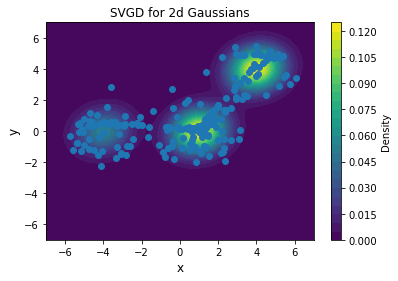

In [6]:
cov = [[0.9, 0.1],
       [0.1, 0.9]]

gauss = GaussianMixture([
    (0.3, [-4., 0.], cov), 
    (0.7, [ 1., 0.], cov),
    (0.7, [ 4., 4.], cov)])

valueRange = (-7, 7)
x0 = sampleInitialParticles((200, 2), valueRange)

rbf = RbfKernel()
svgd = SVGD(rbf, gauss.pdf, 0.1)
particlePlot(svgd, x0, valueRange, valueRange, 'media/animation.mp4')